In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dmol
from dmol import color_cycle

In [190]:
image = plt.imread("quadimg.png")
# the image is 32 x 32 x 4, a 32 by 32 image with four channels, the last one being the alpha channel
print(image.shape)

(32, 32, 4)


In [191]:
# dropping the alpha channel
image = image[...,:3]
print(image.shape)

(32, 32, 3)


In [192]:
# making a test 3 x 3 image with three channels
test_image = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],[[1, 1, 1], [1, 1, 1], [1, 1, 1]],[[1, 1, 1], [1, 1, 1], [1, 1, 1]]])
print(test_image.shape)
test_image = np.pad(test_image, ((1, 1), (1, 1), (0, 0)), mode="constant", constant_values=0.2)
print(test_image.shape)
# we do not change the number of channels, we pad the border of each channel with one pixel wide of 0 padding

(3, 3, 3)
(5, 5, 3)


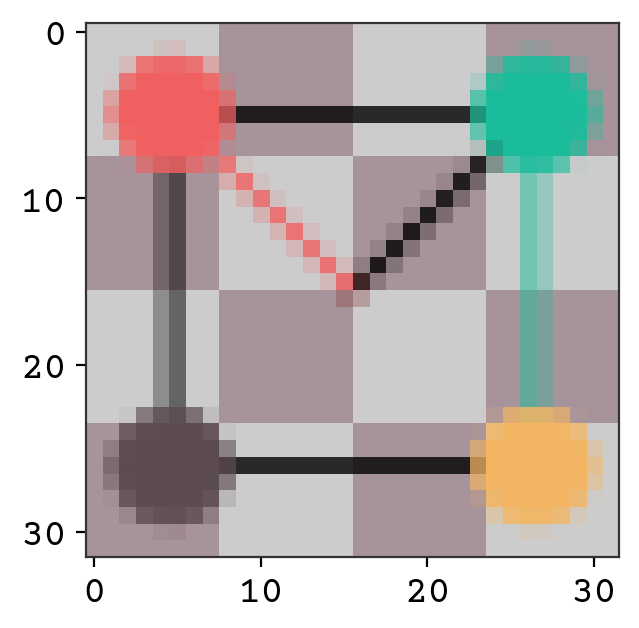

In [193]:
W = 32
func_vals = plt.imread("quadimg.png")[..., :3]
plt.imshow(func_vals)

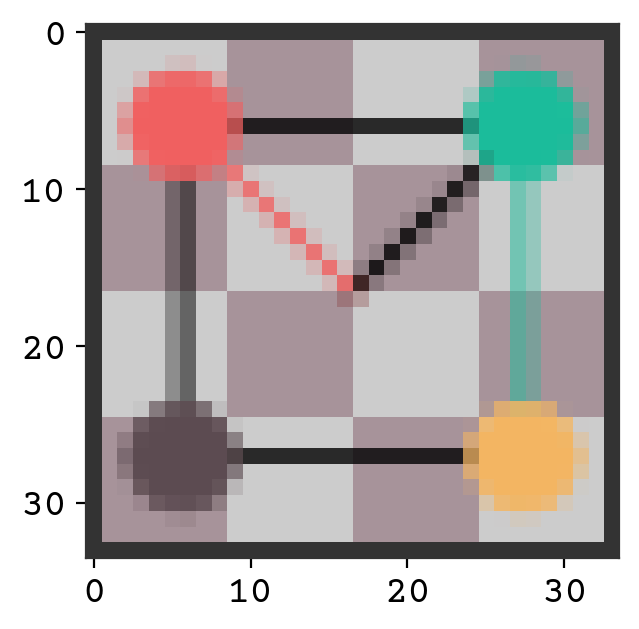

In [194]:
# np.pad ((before_pad, after_pad), (), (), ..., ()) for each axis
func_vals = np.pad(
    func_vals, ((1, 1), (1, 1), (0, 0)), mode="constant", constant_values=0.2
)
plt.imshow(func_vals)

In [195]:
def pix_func(x):
    # np.squeeze(): used for we want to remove single dimensional entries from the shape of an array
    # np.clip(): limits the values in an array, clips all values to the max and min given
    # np.round(x): rounds to the nearest int 
    # clip & squeeze & round to account for transformed values
    xclip = np.squeeze(np.clip(np.round(x), -W // 2 - 1, W // 2)).astype(int)
    # points are centered, fix that
    xclip += [W // 2 , W // 2, 0]
    # add 1 to account for padding
    return func_vals[xclip[..., 0] + 1, xclip[..., 1] + 1]

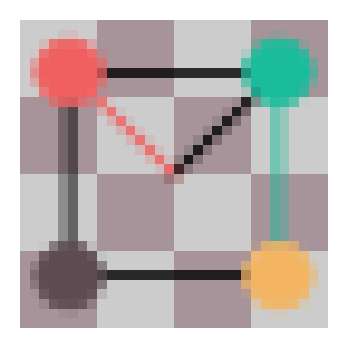

In [196]:
def plot_func(f, ax=None):
    # if the axes is none, gets the current axes or creates it
    if ax is None:
        plt.figure(figsize=(2, 2))
        ax = plt.gca()
    
    # generates indexes for a 32 by 32 image
    gridx, gridy = np.meshgrid(
        np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing="ij"
    )
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    # the indeces start at - w // 2, and end at w // 2 - 1
    # gonna guess that the representation that we want is with negative indeces, but func_vals's indeces cannot start at - w // 2
    batched_idx = np.vstack(
        (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))
    ).T
    ax.imshow(f(batched_idx).reshape(W, W, 3), origin="upper")
    ax.axis("off")


plot_func(pix_func)

In [197]:
# so meshgrid essentially creates a series of indexes to allow iteration over the entire area of the image
gx, gy = np.meshgrid(np.arange(1, 3), np.arange(1, 3), indexing='ij')
print(gx, gy)
print(gx.flatten(), gy.flatten())

[[1 1]
 [2 2]] [[1 2]
 [1 2]]
[1 1 2 2] [1 2 1 2]


In [198]:
stack = np.vstack((gx.flatten(), gy.flatten(), np.ones_like(gx.flatten())))
print(stack.T)
# now each array in the large array is a index for the image that we want to cover, with a dummy 1 as the third element

[[1 1 1]
 [1 2 1]
 [2 1 1]
 [2 2 1]]


In [199]:
def make_h(rot, mirror):
    """Make h subgroup element"""
    m = np.eye(3)
    if mirror:
        m = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]])
    r = np.array([[np.cos(rot), -np.sin(rot), 0], [np.sin(rot), np.cos(rot), 0], [0, 0, 1]])
    return r @ m

In [200]:
rot_pi_mirror = make_h(np.pi, True)
rot_pi_mirror

array([[ 1.0000000e+00, -1.2246468e-16,  0.0000000e+00],
       [-1.2246468e-16, -1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [201]:
def make_n(dx, dy):
    """Make normal subgroup element"""
    return np.array([[1, 0, dx],[0, 1, dy],[0, 0, 1]])

In [202]:
make_n(1, 3)

array([[1, 0, 1],
       [0, 1, 3],
       [0, 0, 1]])

$$ f'(gx) = f(g^{-1}x) $$

In [203]:
def g_func_trans(g, f):
    """Compute g-function transform"""

    # returns the function f after it was transformed by the given transformation matrix g
    def fxn(x, g=g, f=f):
        ginv = np.linalg.inv(g)
        return f(ginv.reshape(1, 3, 3) @ x.reshape(-1, 3, 1))
    
    return fxn

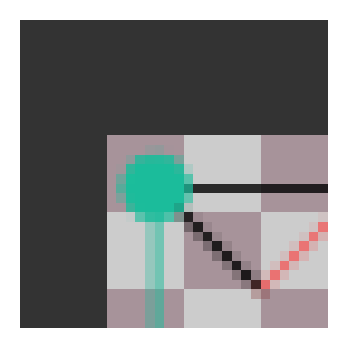

In [204]:
g = make_h(np.pi, 1) @ make_n(12, -8)
# tfunc is the transformed f after applying a g function transform to it
tfunc = g_func_trans(g, pix_func)
plot_func(tfunc)

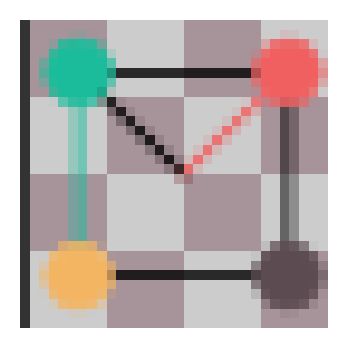

In [205]:
# think its actually off by one, but ok 
g2 = make_h(np.pi, 1)
tfunc2 = g_func_trans(g2, pix_func)
plot_func(tfunc2)

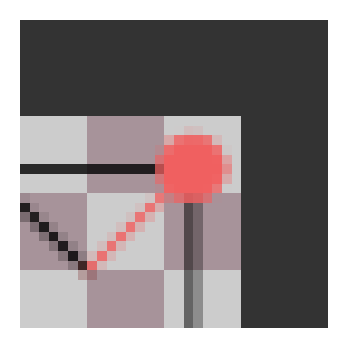

In [206]:
g3 = make_h(np.pi, 1) @ make_n(10, 10)
tfunc3 = g_func_trans(g3, pix_func)
plot_func(tfunc3)

First we define a subgroup H, and then we apply an element g to every element in H. 

$$gH = \{g \cdot h\forall h \, \epsilon \,  H \} $$

We pick an arbitrary point in the space $x_0$, then we choose our subgroup H to be all group elements that leave $x_0$ unchangd, this is the stabilizer subgroup.

In [207]:
# enumerate stabilizer subgroup (all rotation/mirrors)
stabilizer = []
for i in range(4):
    for j in range(2):
        stabilizer.append(make_h(i * np.pi / 2, j))

Lifting:

$$ f \uparrow^G (g) = f(gx_0) $$

In [208]:
def lift(f):
    def fxn(g, f=f):
        return f(g @ np.array([0, 0, 1]))
    return fxn

Projecting:

$$ f \downarrow_x (x) = \frac{1}{|H_0|} \sum_{u \epsilon gH_0} f(u), gx_0 = x $$

In [209]:
def project(f):
    
    def fxn(x, f=f):
        x = np.array(x).reshape((-1, 3))
        out = np.zeros((x.shape[0], 3))
        for i, xi in enumerate(x):
            # translation
            g = make_n(xi[0], xi[1])
            # loop over coset
            for h in stabilizer:
                ghi = g @ h
                out[i] += f(ghi)
            out[i] /= len(stabilizer)
        return out
    
    return fxn

In [210]:
kernel_width = 5  # must be odd
# make some random values for kernel (untrained)
# kernel is group elements x 3 x 3. The group elements are structured (for simplicity) as a N x 5 x 5
# the 3 x 3 part is because we have 3 color channels coming in and 3 going out.
kernel = np.random.uniform(
    -0.5, 0.5, size=(len(stabilizer), kernel_width, kernel_width, 3, 3)
)

In [211]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def conv(f, p=kernel):
    def fxn(u):
        # It is possible to do this without inner for
        # loops over convolution (use a standard conv),
        # but we do this for simplicity.
        result = 0
        for hi, h in enumerate(stabilizer):
            for nix in range(-kernel_width // 2, kernel_width // 2 + 1):
                for niy in range(-kernel_width // 2, kernel_width // 2 + 1):
                    result += (
                        f(u @ make_n(-nix, -niy) @ np.linalg.inv(h))
                        @ kernel[hi, nix + kernel_width // 2, niy + kernel_width // 2]
                    )
        return sigmoid(result)

    return fxn


# compute convolution
cout = conv(lift(pix_func))
# try it out an a group element
cout(g)

array([1.05730277e-03, 6.78471822e-07, 8.35992302e-04])

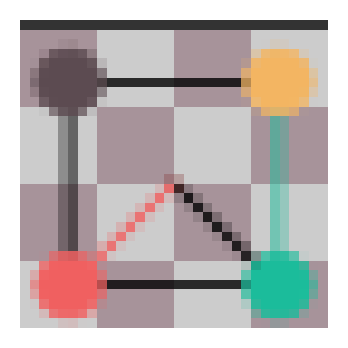

In [212]:
def plot_coset(h, f, ax):
    """plot a function over group elements on cosets given representative g"""
    gridx, gridy = np.meshgrid(
        np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing="ij"
    )
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack(
        (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))
    ).T
    values = np.zeros((W**2, 3))
    for i, bi in enumerate(batched_idx):
        values[i] = f(h @ make_n(bi[0], bi[1]))
    ax.imshow(values.reshape(W, W, 3), origin="upper")
    ax.axis("off")


# try it with mirror
plt.figure(figsize=(2, 2))
plot_coset(make_h(0, 1), lift(pix_func), ax=plt.gca())

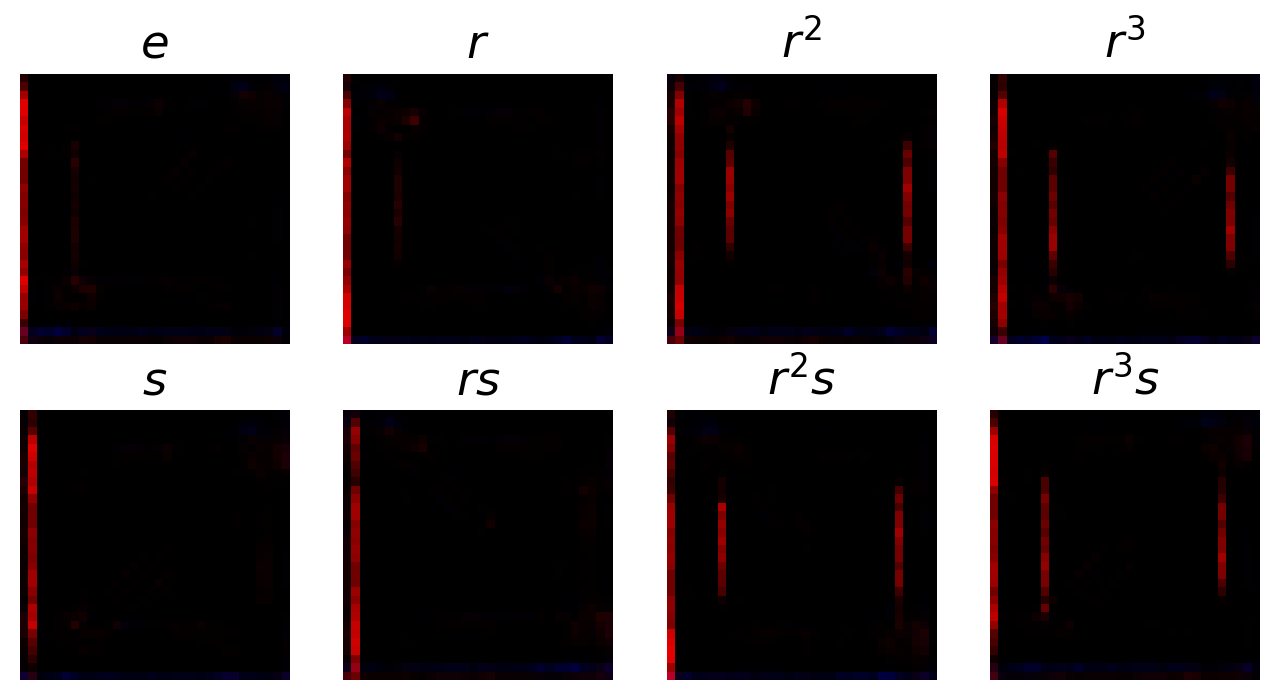

In [213]:
stabilizer_names = ["$e$", "$r$", "$r^2$", "$r^3$", "$s$", "$rs$", "$r^2s$", "$r^3s$"]
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
axs = axs.flatten()
for i, (n, h) in enumerate(zip(stabilizer_names, stabilizer)):
    ax = axs[i]
    plot_coset(h, cout, ax)
    ax.set_title(n)